# This will be an attempted replication of the Lind 2018 paper, and will draw from previous notebooks while removing the seasonal signal

This will make ~4 plots:
- 3x3: the SST, SSS, SIC as an average for the year 2013--2017 (low sea ice years) vs 2003--2007 (high sea ice years); the anomalies between them
- heat plot 2x2: the changes in heat content of the upper 100m during the ASTE period, the temperature profile of this nortnern section, the upper ocean (100 m heat content in this region, the arctic water thickness in this region
- salt plot 2x2: the changes in freshwater content of the upper 100m during the ASTE period, the timeseries of this freshwater content, the sea ice area import compared with the difference across the two pathways, the anomaly of the SSS compared with the sea ice extent

# import packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.dates as mdates
import matplotlib.colors as mcolors

In [86]:
%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [4]:
path = "/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/Lind2018/LindFigures/"

# First we need to plot the polar front/our 3x3 file

In [5]:
# load the files we need to do this
# load the timesteps
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

# ocean and ice
AB_gT=0
AB_gS=0

allyears = np.arange(2003,2018,1)
dterm = 10                 # set a terminal depth for freshwater and heat calculations 19:276m   and    10:100m

In [6]:
# how do we check the dterm?
np.cumsum(mygrid['DRF'])[:dterm]

array([ 10.  ,  20.  ,  30.  ,  40.  ,  50.  ,  60.  ,  70.  ,  80.01,
        90.04, 100.15])

In [7]:
# load the existing mask of the Barents Sea -- this is what we will work from 
whole = True
if not whole:
    iB = 6    # example read from BarentsSea
    
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()
mask = ~np.isnan(mymsk)
mask = mymsk == 6

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


In [9]:
# loop through the years to create the timeseries
# alldatetimes = np.array([])
# FW_times = np.array([])
# Heat_times = np.array([])  # this does not make sense as variable name

# we want vertically-integrated heat content: shape times,month,ny,nx
heat_content = np.full((len(allyears),12,ny,nx),np.nan)
fw_content = np.full((len(allyears),12,ny,nx),np.nan)

iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ##########################################################################################
    # get the volume values

    # for mass tendency (m^3/s) - time is not yet included in this block
    file_name = 'budg2d_snap_set1'
    
    # assuming all files are structured the same
    meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
    # try to read this with rec
    fldlist = np.array(meta_budg2d_snap_set1['fldList'])
    varnames = np.array(['ETAN'])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    
    # set for all months
    vol = np.full((len(tsstr),nz, ny, nx),np.nan)
    ETANS = np.full((len(tsstr),ny,nx),np.nan)
    print("volume allocation shape",vol.shape)
    
    for t in range(len(tsstr)):
        t1 = tsstr[t]
        read = [int(t1)]
    
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])
    
        # choose by basin
        ETAN = np.reshape(ETAN,(ny,nx)) #* wetmask[0,:,:]
    
        # ocean
        if debug:
            print(read,its[0],its[1]) # these iteration numbers should be the same as read
    
        # 3D, with rStar:
        tmpvol = np.zeros((nz, ny, nx))
        if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
            tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
            if myparms['useRFWF'] == 0:
                tmpvol[0, :, :] = np.zeros((ny, nx))
        else:    # 4/22 look at this one
            if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
                tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
                tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
            else:
                tmp2 = drf3d / mk3D_mod(DD, tmp1)
    
            # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
            tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) #* mk3D_mod(RAC, hfC) * ffac     # volume, m * m^2  = m^3
    
        vol[t,:,:,:] = tmpvol

    ##########################################################################################
    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

    # get theta and salt alone so we can use for the freshwater content
    THETA = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    SALT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
        THETA[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']  # degC
        SALT[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']   # PSU

    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        
        thisTHETADR = THETADR[i]/DRF3d/mygrid['hFacC'] * mymsk[np.newaxis,:,:]    # degC
        thisheat = thisTHETADR * myparms['rcp']   # degC * J/m^3.degC = J/m^3
        thisheat = thisheat * tmpvol[i]     # J/m^3 * m^3 = J
        thisheat = thisheat[:dterm]   # upper mygrid['DRF'][:dterm] m


        heat_content[iy,i,:,:] = np.nansum(thisheat,axis=0)            # vertical integration (J)

    ##########################################################################################
    # get the freshwater content values
    # set up for time averaging
    sref = 34.8#41.05      # PSU
    # filter = drf3d.copy() * mygrid['hFacC']
    # filter[filter >= 254] = np.nan
    # filter[filter < 254] = 1
    FWcontent = np.full((len(tsstr),ny,nx),np.nan)
    
    for i in range(len(tsstr)): 
        # for calculating freshwater content:
            # FW volume * (1- salinity/reference salinity)    m^3
            # integrate over surface to mygrid['DRF'][:dterm] m based on the np.where(np.cumsum(mygrid['DRF'])<X meters deep)
            # look at the time average of this
        
        # do step 1 to get FW volume and only look at the values at less than X m
        saltnorm = 1-(SALT[i]/sref)         # PSU/PSU
        FWvol = vol[i] * (1-SALT[i]/sref)   # m^3 * PSU/PSU
        FWvol /=  RAC3                      # m
        FWvol = FWvol[:dterm]
        
        # vertically integrate
        FWcontent[i] = np.nansum(FWvol,axis=0) * mymsk          # vertical integration, m

        # add as a map to the bigger array
        fw_content[iy,i,:,:] = FWcontent[i]

    print()
    iy += 1

2003
volume allocation shape (12, 50, 1350, 270)

2004
volume allocation shape (12, 50, 1350, 270)

2005
volume allocation shape (12, 50, 1350, 270)

2006
volume allocation shape (12, 50, 1350, 270)

2007
volume allocation shape (12, 50, 1350, 270)

2008
volume allocation shape (12, 50, 1350, 270)

2009
volume allocation shape (12, 50, 1350, 270)

2010
volume allocation shape (12, 50, 1350, 270)

2011
volume allocation shape (12, 50, 1350, 270)

2012
volume allocation shape (12, 50, 1350, 270)

2013
volume allocation shape (12, 50, 1350, 270)

2014
volume allocation shape (12, 50, 1350, 270)

2015
volume allocation shape (12, 50, 1350, 270)

2016
volume allocation shape (12, 50, 1350, 270)

2017
volume allocation shape (12, 50, 1350, 270)



In [87]:
# heat_content.shape # vertically integrated heat content for the whole domain for each year, month
# LANDMSK CANNOT BE USED UNTIL WE USE THE HFACC

# # load the landmask
# hfac = mygrid['hFacC']
# landmsk = hfac[0]
# landmsk[np.isnan(landmsk)] = 2
# landmsk[landmsk == 1] = np.nan
# plt.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0])
# plt.colorbar()

In [11]:
# do the sea ice area as a map
si_area_all = np.full((len(allyears),12,ny,nx),np.nan)
iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    # get the SIarea values

    SIarea = np.full((len(tsstr),ny,nx),np.nan)  # 2D field 
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_2d_set1'
        meta_state_2d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_2d_set1["fldList"])
        varnames = np.array(["SIarea"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        # this is wrong, this is the fractional area -- to get the actual area we need to multiply by RAC
        SIareai,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # m^2/m^2
        SIarea[i,:,:] = np.reshape(SIareai,(ny,nx))*mymsk*RAC  # m^2

        # get the total SIarea for that time
        si_area_all[iy,i,:,:] = SIarea[i,:,:]

    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


# Skip the following if we have already created the masks

In [23]:
# set up the arrays
heat_content5yrs = np.full((3,ny,nx),np.nan)
fw_content5yrs = np.full((3,ny,nx),np.nan)
si_area_all5yrs = np.full((3,ny,nx),np.nan)

In [24]:
start = 0
for i in range(3):
    heat_content_avg = np.mean(heat_content[start:start+5, :, :, :], axis=0)     # average for the years
    heat_content_avg = np.mean(heat_content_avg[:, :, :], axis=0)                # average across all months
    heat_content5yrs[i] = heat_content_avg

    fw_content_avg = np.mean(fw_content[start:start+5, :, :, :], axis=0)
    fw_content_avg = np.mean(fw_content_avg[:, :, :], axis=0)
    fw_content5yrs[i] = fw_content_avg


    # for SIarea it makes more sense to do this for winter (months 0,1,2) 
    si_area_avg = np.mean(si_area_all[start:start+5, :3, :, :], axis=0)
    si_area_avg = np.mean(si_area_avg,axis=0)
    si_area_all5yrs[i] = si_area_avg
    
    start += 5

In [31]:
# create the masks -- one is warming and salting and the other is warming and freshening
a = heat_content5yrs[0]
b = heat_content5yrs[2]
c = b-a
d = fw_content5yrs[0]
e = fw_content5yrs[2]
f = e-d

# mask for the heating and freshening (southern portion)
msk1 = np.zeros((ny,nx))
msk1[(c > 0) & (f > 0)] = 1

# mask for the heating and salting (northern portion)
msk2 = np.zeros((ny,nx))
msk2[(c > 0) & (f < 0)] = 1

# mask included in the northern portion as the maximum of the others
msk3 = np.zeros((ny,nx))
msk3[(c > 2e8) & (f <-.3e-8) ] = 1

np.savez('masks.npz', msk1=msk1, msk2=msk2, msk3=msk3)

In [32]:
# Load the .npz file
data = np.load('masks.npz')

# Access the saved masks
msk1 = data['msk1']  # mask for heating and freshening
msk2 = data['msk2']  # mask for heating and salting
msk3 = data['msk3']  # mask for maximum location of change for heating and salting

In [64]:
hfC[hfC == 2] = 1

## plot the averages for the 5 year periods

In [89]:
# do this by looping through the salt and heat -- we want to make an average of these as depth
theta_dist1 = np.zeros((len(allyears),12,nz))
salt_dist1 = np.zeros((len(allyears),12,nz))

# for heating and salting portion -- see if this is different
theta_dist2 = np.zeros((len(allyears),12,nz))
salt_dist2 = np.zeros((len(allyears),12,nz))

# for heating and salting portion -- see if this is different
theta_dist3 = np.zeros((len(allyears),12,nz))
salt_dist3 = np.zeros((len(allyears),12,nz))

# do indexing in years for the layers
iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ##########################################################################################
    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        # do the depth meaning for theta
        thisTHETA = THETADR[i]/DRF3d/hfC * np.tile(msk1[np.newaxis,:,:],(50,1,1))    # degC
        thisTHETA[thisTHETA == 0] = np.nan   # this was messing up averaging without this precaution
        theta_dist1[iy,i,:] = np.nanmean(thisTHETA, axis = (1,2))  # depth average of shape nz
        thisTHETA = THETADR[i]/DRF3d/hfC * np.tile(msk2[np.newaxis,:,:],(50,1,1))    # degC
        thisTHETA[thisTHETA == 0] = np.nan
        theta_dist2[iy,i,:] = np.nanmean(thisTHETA, axis = (1,2))
        thisTHETA = THETADR[i]/DRF3d/hfC * np.tile(msk3[np.newaxis,:,:],(50,1,1))    # degC
        thisTHETA[thisTHETA == 0] = np.nan
        theta_dist3[iy,i,:] = np.nanmean(thisTHETA, axis = (1,2))

        # do the depth averaging for freshwater
        thisSALT = SALTDR[i]/DRF3d/hfC * np.tile(msk1[np.newaxis,:,:],(50,1,1))    # PSU
        thisSALT[thisSALT == 0] = np.nan
        salt_dist1[iy,i,:] = np.nanmean(thisSALT, axis = (1,2))  # depth average of shape nz
        thisSALT = SALTDR[i]/DRF3d/hfC * np.tile(msk2[np.newaxis,:,:],(50,1,1))    # PSU
        thisSALT[thisSALT == 0] = np.nan
        salt_dist2[iy,i,:] = np.nanmean(thisSALT, axis = (1,2))
        thisSALT = SALTDR[i]/DRF3d/hfC * np.tile(msk3[np.newaxis,:,:],(50,1,1))    # PSU
        thisSALT[thisSALT == 0] = np.nan
        salt_dist3[iy,i,:] = np.nanmean(thisSALT, axis = (1,2))

    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


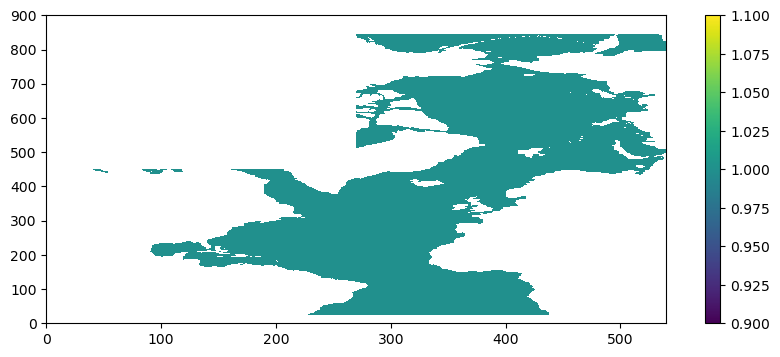

In [100]:
# plt.pcolormesh(get_aste_tracer(SALTDR[i]/DRF3d/hfC,nfx,nfy)[0])
plt.pcolormesh(get_aste_tracer(hfC,nfx,nfy)[0])

plt.colorbar()

# Figure 0: the SSS, SST, and SIC of the years we have

In [34]:
# what are the variables we need
    # SSS: need to load from salt
    # SST: need to load from temperature
    # SIC: we have this in the form of si_area_all for the 15 years

## sample just looking at SST and SSS to compare to surface 100m

In [97]:
# we need to load the data in the arrays for SSS and SST because we had been doing heat before
SST_all = np.full((len(allyears),12,ny,nx),np.nan)
SSS_all = np.full((len(allyears),12,ny,nx),np.nan)         # only need 2d because we will only store the surface layer


# loop through the years to create the timeseries
# alldatetimes = np.array([])
# FW_times = np.array([])
# Heat_times = np.array([])  # this does not make sense as variable name

iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ##########################################################################################
    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

    # get theta and salt alone so we can use for the freshwater content
    THETA = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    SALT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
        THETA[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']  # degC
        SALT[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']   # PSU

    # add only the surface values to the array
    for i in range(len(tsstr)): 
        SST_all[iy,i,:,:] = THETA[i,0,:,:]
        SSS_all[iy,i,:,:] = SALT[i,0,:,:]
        
    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [98]:
# do the 5 year averages and the anomaly of the SST and SSS
SST1 = np.nanmean(SST_all[:5],axis = (0,1))
SST2 = np.nanmean(SST_all[-5:],axis = (0,1))
SSTa = SST2 - SST1

SSS1 = np.nanmean(SSS_all[:5],axis = (0,1))
SSS2 = np.nanmean(SSS_all[-5:],axis = (0,1))
SSSa = SSS2 - SSS1

In [99]:
# also do for SIC
SIC1 = np.nanmean(si_area_all[:5,:5],axis = (0,1))
SIC2 = np.nanmean(si_area_all[-5:,:5],axis = (0,1))      # Jan-May for winter
SICa = SIC2 - SIC1

In [ ]:
# do the averaging so we can make a plot - regardless of if it is pretty; we need to do the two 5 year periods then anomaly
# plot just these three
fig = plt.figure(figsize = (12,4))

# First subplot: SST for the first 5 years
ax = plt.subplot(131)
cb = ax.pcolormesh(get_aste_tracer(SSTa * mymsk, nfx, nfy)[0], 
                   alpha=1, cmap="seismic",vmin=-2,vmax=2)
plt.colorbar(cb,label="SST (degrees)")
# Set axis limits
ax.set_xlim(420, 515)
ax.set_ylim(430, 560)
ax.contourf(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=5,levels=np.arange(-1,6,1))
ax.set_title("SST Avg.")

# Second subplot: SSS for the first 5 years
ax = plt.subplot(132)
cb = ax.pcolormesh(get_aste_tracer(SSSa * mymsk, nfx, nfy)[0], 
                   alpha=1, cmap="seismic",vmin=-1,vmax=1)
plt.colorbar(cb,label="SSS (PSU)")
# Set axis limits
ax.set_xlim(420, 515)
ax.set_ylim(430, 560)
ax.contourf(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=5,levels=np.arange(-1,6,1))
ax.set_title("SSS Avg.")

# Third subplot: SIC average for the first 5 years
ax = plt.subplot(133)
cb = ax.pcolormesh(get_aste_tracer(SICa * mymsk, nfx, nfy)[0], 
                   alpha=1, cmap="seismic",vmin=-5e7,vmax=5e7)
plt.colorbar(cb,label="SIC")
# Set axis limits
ax.set_xlim(420, 515)
ax.set_ylim(430, 560)
ax.contourf(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=5,levels=np.arange(-1,6,1))
ax.set_title("SIC Jan-May Avg.")

fig.tight_layout(pad=2.0)  # Increase padding between subplots
plt.suptitle("Surface Anomalies '13-'17 -- '03-'07")

# plt.savefig(path + "surface_anomalies.png",dpi=300)

In [105]:
# another plot -- the gradients of the SST and SSS for the first and last 5 years and for the whole time

# get the gradients of the values
grad_x, grad_y = np.gradient(SST_all, axis=(-2, -1))
grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
SST_grad = np.mean(grad_magnitude, axis=(0, 1))

print(SST_grad.shape)

# get the gradients of the values
grad_x, grad_y = np.gradient(SSS_all, axis=(-2, -1))
grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
SSS_grad = np.mean(grad_magnitude, axis=(0, 1))

print(SSS_grad.shape)

(1350, 270)
(1350, 270)


In [106]:
# get the gradients of the values
SST_test = np.nanmean(SST_all, axis=(0,1))
SST_test = get_aste_tracer(SST_test * mymsk,nfx,nfy)[0]
grad_x, grad_y = np.gradient(SST_test, axis=(-2, -1))
SST_grad = np.sqrt(grad_x**2 + grad_y**2)
print(SST_grad.shape)

# get the gradients of the values
SSS_test = np.nanmean(SSS_all, axis=(0,1))
SSS_test = get_aste_tracer(SSS_test * mymsk,nfx,nfy)[0]
grad_x, grad_y = np.gradient(SSS_test, axis=(-2, -1))
SSS_grad = np.sqrt(grad_x**2 + grad_y**2)

print(SSS_grad.shape)

(900, 540)
(900, 540)


In [86]:
# for the first 5 years
# get the gradients of the values
SST_test = np.nanmean(SST_all[:5], axis=(0,1))
SST_test = get_aste_tracer(SST_test * mymsk,nfx,nfy)[0]
grad_x, grad_y = np.gradient(SST_test, axis=(-2, -1))
SST_grad1 = np.sqrt(grad_x**2 + grad_y**2)
print(SST_grad1.shape)

# get the gradients of the values
SSS_test = np.nanmean(SSS_all[:5], axis=(0,1))
SSS_test = get_aste_tracer(SSS_test * mymsk,nfx,nfy)[0]
grad_x, grad_y = np.gradient(SSS_test, axis=(-2, -1))
SSS_grad1 = np.sqrt(grad_x**2 + grad_y**2)

print(SSS_grad1.shape)

(900, 540)
(900, 540)


In [87]:
# for the last 5 years
# get the gradients of the values
SST_test = np.nanmean(SST_all[-5:], axis=(0,1))
SST_test = get_aste_tracer(SST_test * mymsk,nfx,nfy)[0]
grad_x, grad_y = np.gradient(SST_test, axis=(-2, -1))
SST_grad2 = np.sqrt(grad_x**2 + grad_y**2)
print(SST_grad2.shape)

# get the gradients of the values
SSS_test = np.nanmean(SSS_all[-5:], axis=(0,1))
SSS_test = get_aste_tracer(SSS_test * mymsk,nfx,nfy)[0]
grad_x, grad_y = np.gradient(SSS_test, axis=(-2, -1))
SSS_grad2 = np.sqrt(grad_x**2 + grad_y**2)

print(SSS_grad2.shape)

(900, 540)
(900, 540)


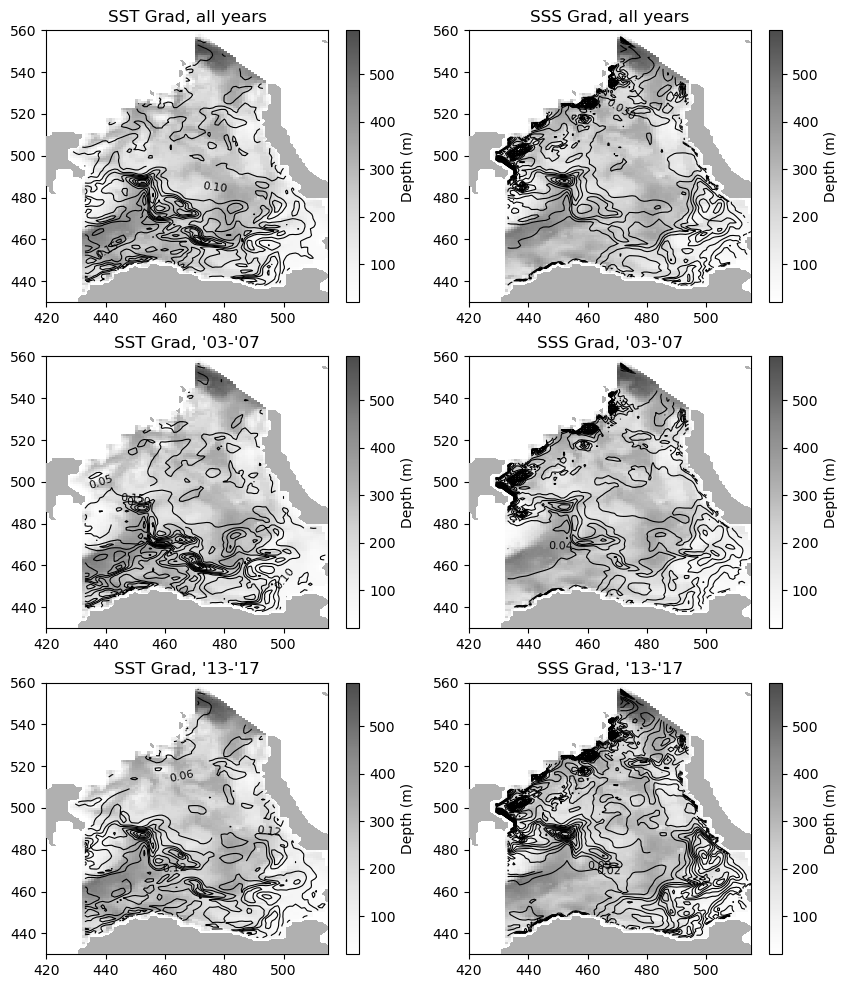

In [89]:
# do the averaging so we can make a plot - regardless of if it is pretty; we need to do the two 5 year periods then anomaly
# plot just these three
fig = plt.figure(figsize = (10,12))

# First subplot: SST for the first 5 years
ax = plt.subplot(321)
cb = ax.pcolormesh(get_aste_tracer(mygrid['Depth'] * mymsk, nfx, nfy)[0], alpha=0.7, cmap="Greys") # depth
# contours = ax.contour(get_aste_tracer(SST_grad * mymsk, nfx,nfy)[0], colors="black", linewidths=0.8, levels=10)  # Adjust levels as needed
contours = ax.contour(SST_grad, colors="black", linewidths=0.8, levels=10)  # Adjust levels as needed
ax.clabel(contours, inline=True, fontsize=8)  # Label the contours
plt.colorbar(cb,label="Depth (m)")
# Set axis limits
ax.set_xlim(420, 515)
ax.set_ylim(430, 560)
ax.contourf(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=5,levels=np.arange(-1,6,1))
ax.set_title("SST Grad, all years")

# Second subplot: SSS for the first 5 years
ax = plt.subplot(322)
cb = ax.pcolormesh(get_aste_tracer(mygrid['Depth'] * mymsk, nfx, nfy)[0], alpha=0.7, cmap="Greys") # depth
# cb = ax.pcolormesh(get_aste_tracer(SSSa * mymsk, nfx, nfy)[0], alpha=1, cmap="seismic",vmin=-1,vmax=1)
contours = ax.contour(SSS_grad, colors="black", linewidths=0.8, levels=50)  # Adjust levels as needed
ax.clabel(contours, inline=True, fontsize=8)  # Label the contours
plt.colorbar(cb,label="Depth (m)")# Set axis limits
ax.set_xlim(420, 515)
ax.set_ylim(430, 560)
ax.contourf(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=5,levels=np.arange(-1,6,1))
ax.set_title("SSS Grad, all years")

############################################################
# for the first five years do the same thing
ax = plt.subplot(323)
cb = ax.pcolormesh(get_aste_tracer(mygrid['Depth'] * mymsk, nfx, nfy)[0], alpha=0.7, cmap="Greys") # depth
# contours = ax.contour(get_aste_tracer(SST_grad * mymsk, nfx,nfy)[0], colors="black", linewidths=0.8, levels=10)  # Adjust levels as needed
contours = ax.contour(SST_grad1, colors="black", linewidths=0.8, levels=10)  # Adjust levels as needed
ax.clabel(contours, inline=True, fontsize=8)  # Label the contours
plt.colorbar(cb,label="Depth (m)")
# Set axis limits
ax.set_xlim(420, 515)
ax.set_ylim(430, 560)
ax.contourf(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=5,levels=np.arange(-1,6,1))
ax.set_title("SST Grad, '03-'07")

# Second subplot: SSS for the first 5 years
ax = plt.subplot(324)
cb = ax.pcolormesh(get_aste_tracer(mygrid['Depth'] * mymsk, nfx, nfy)[0], alpha=0.7, cmap="Greys") # depth
# cb = ax.pcolormesh(get_aste_tracer(SSSa * mymsk, nfx, nfy)[0], alpha=1, cmap="seismic",vmin=-1,vmax=1)
contours = ax.contour(SSS_grad1, colors="black", linewidths=0.8, levels=50)  # Adjust levels as needed
ax.clabel(contours, inline=True, fontsize=8)  # Label the contours
plt.colorbar(cb,label="Depth (m)")# Set axis limits
ax.set_xlim(420, 515)
ax.set_ylim(430, 560)
ax.contourf(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=5,levels=np.arange(-1,6,1))
ax.set_title("SSS Grad, '03-'07")

############################################################
# for the last five years do the same thing
ax = plt.subplot(325)
cb = ax.pcolormesh(get_aste_tracer(mygrid['Depth'] * mymsk, nfx, nfy)[0], alpha=0.7, cmap="Greys") # depth
# contours = ax.contour(get_aste_tracer(SST_grad * mymsk, nfx,nfy)[0], colors="black", linewidths=0.8, levels=10)  # Adjust levels as needed
contours = ax.contour(SST_grad2, colors="black", linewidths=0.8, levels=10)  # Adjust levels as needed
ax.clabel(contours, inline=True, fontsize=8)  # Label the contours
plt.colorbar(cb,label="Depth (m)")
# Set axis limits
ax.set_xlim(420, 515)
ax.set_ylim(430, 560)
ax.contourf(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=5,levels=np.arange(-1,6,1))
ax.set_title("SST Grad, '13-'17")

# Second subplot: SSS for the first 5 years
ax = plt.subplot(326)
cb = ax.pcolormesh(get_aste_tracer(mygrid['Depth'] * mymsk, nfx, nfy)[0], alpha=0.7, cmap="Greys") # depth
# cb = ax.pcolormesh(get_aste_tracer(SSSa * mymsk, nfx, nfy)[0], alpha=1, cmap="seismic",vmin=-1,vmax=1)
contours = ax.contour(SSS_grad2, colors="black", linewidths=0.8, levels=50)  # Adjust levels as needed
ax.clabel(contours, inline=True, fontsize=8)  # Label the contours
plt.colorbar(cb,label="Depth (m)")# Set axis limits
ax.set_xlim(420, 515)
ax.set_ylim(430, 560)
ax.contourf(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=5,levels=np.arange(-1,6,1))
ax.set_title("SSS Grad, '13-'17")


plt.savefig(path + "allgradients.png",dpi=300)

In [21]:
# plot the northern and southern portions and the anomalies for the 5-year periods

# Figure 2

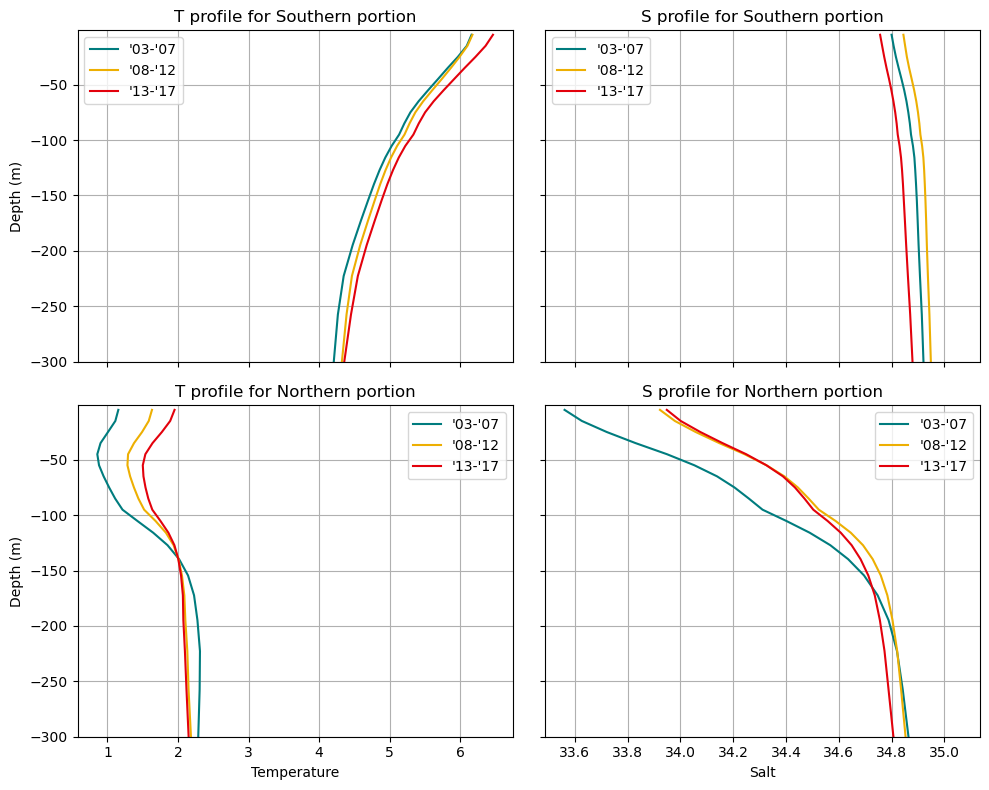

In [92]:
# plot the vertical profiles for the two sections

# colors
c1 = '#007c7e'
c2 = '#edaf02'
c3 = '#e3010c'

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex='col', sharey=True)

# First plot: Temperature profile for Southern portion
axes[0, 0].plot(np.nanmean(theta_dist1[:5], axis=(0, 1)), mygrid['RC'], label="'03-'07",color=c1)
axes[0, 0].plot(np.nanmean(theta_dist1[5:10], axis=(0, 1)), mygrid['RC'], label="'08-'12",color=c2)
axes[0, 0].plot(np.nanmean(theta_dist1[10:], axis=(0, 1)), mygrid['RC'], label="'13-'17",color=c3)
axes[0, 0].set_ylim(-300, -1)
axes[0, 0].set_title("T profile for Southern portion")
axes[0, 0].legend()
axes[0, 0].grid()
axes[0, 0].set_ylabel("Depth (m)")  # Y-axis label

# Second plot: Salinity profile for Southern portion
axes[0, 1].plot(np.nanmean(salt_dist1[:5], axis=(0, 1)), mygrid['RC'], label="'03-'07",color=c1)
axes[0, 1].plot(np.nanmean(salt_dist1[5:10], axis=(0, 1)), mygrid['RC'], label="'08-'12",color=c2)
axes[0, 1].plot(np.nanmean(salt_dist1[10:], axis=(0, 1)), mygrid['RC'], label="'13-'17",color=c3)
axes[0, 1].set_ylim(-300, -1)
axes[0, 1].set_title("S profile for Southern portion")
axes[0, 1].legend()
axes[0, 1].grid()

# Third plot: Temperature profile for Northern portion
axes[1, 0].plot(np.nanmean(theta_dist2[:5], axis=(0, 1)), mygrid['RC'], label="'03-'07",color=c1)
axes[1, 0].plot(np.nanmean(theta_dist2[5:10], axis=(0, 1)), mygrid['RC'], label="'08-'12",color=c2)
axes[1, 0].plot(np.nanmean(theta_dist2[10:], axis=(0, 1)), mygrid['RC'], label="'13-'17",color=c3)
axes[1, 0].set_ylim(-300, -1)
axes[1, 0].set_title("T profile for Northern portion")
axes[1, 0].legend()
axes[1, 0].grid()
axes[1, 0].set_xlabel("Temperature")  # X-axis label
axes[1, 0].set_ylabel("Depth (m)")  # Y-axis label

# Fourth plot: Salinity profile for Northern portion
axes[1, 1].plot(np.nanmean(salt_dist2[:5], axis=(0, 1)), mygrid['RC'], label="'03-'07",color=c1)
axes[1, 1].plot(np.nanmean(salt_dist2[5:10], axis=(0, 1)), mygrid['RC'], label="'08-'12",color=c2)
axes[1, 1].plot(np.nanmean(salt_dist2[10:], axis=(0, 1)), mygrid['RC'], label="'13-'17",color=c3)
axes[1, 1].set_ylim(-300, -1)
axes[1, 1].set_title("S profile for Northern portion")
axes[1, 1].legend()
axes[1, 1].grid()
axes[1, 1].set_xlabel("Salt")  # X-axis label

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig(path + "profiles_100m_2sets.png", dpi=300)

# print("Profiles saved to 'profiles.png'")

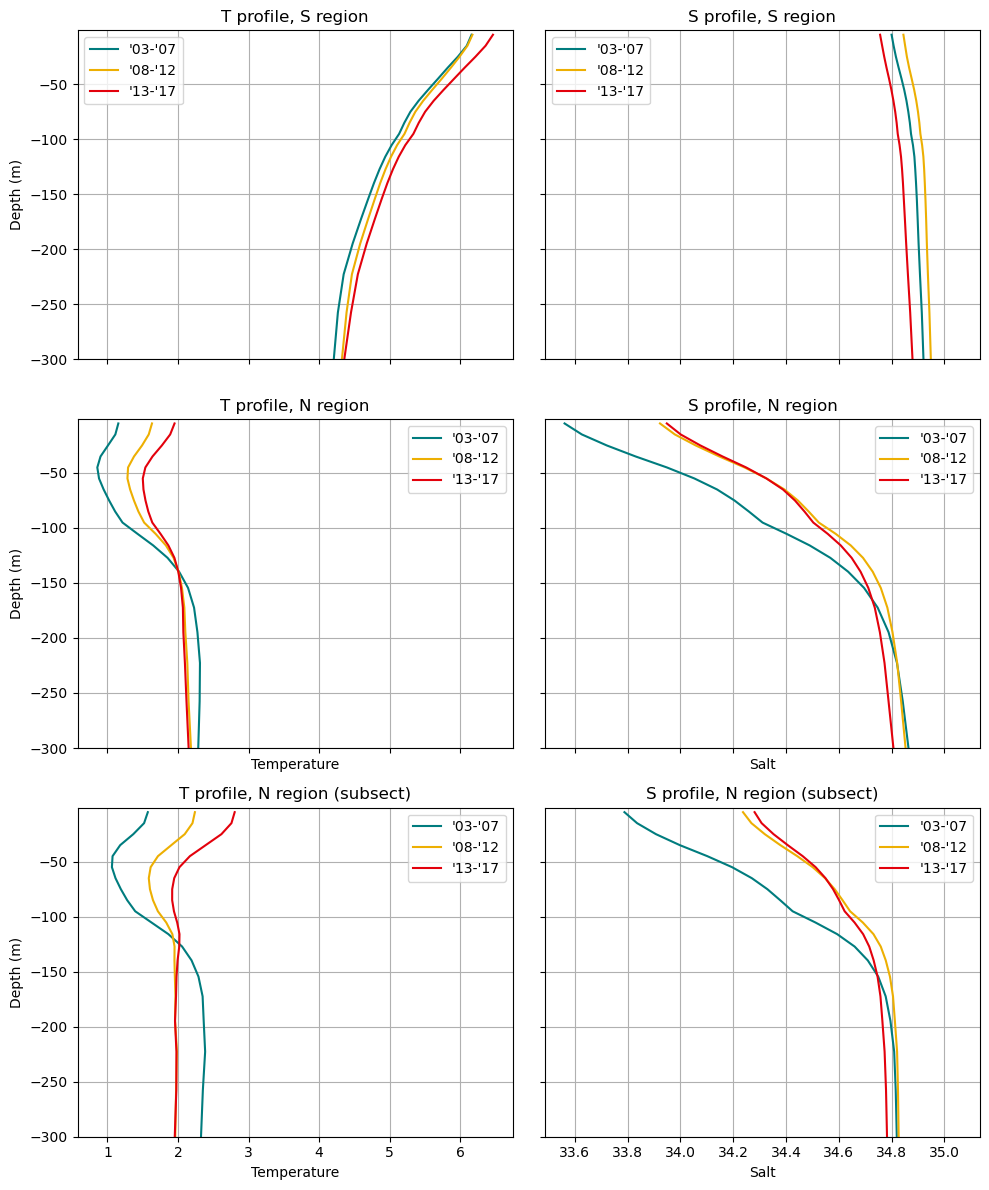

In [103]:
# also do the profiles including msk3
# plot the vertical profiles for the two sections

# colors
c1 = '#007c7e'
c2 = '#edaf02'
c3 = '#e3010c'

fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex='col', sharey=True)

# First plot: Temperature profile for Southern portion
axes[0, 0].plot(np.nanmean(theta_dist1[:5], axis=(0, 1)), mygrid['RC'], label="'03-'07",color=c1)
axes[0, 0].plot(np.nanmean(theta_dist1[5:10], axis=(0, 1)), mygrid['RC'], label="'08-'12",color=c2)
axes[0, 0].plot(np.nanmean(theta_dist1[10:], axis=(0, 1)), mygrid['RC'], label="'13-'17",color=c3)
axes[0, 0].set_ylim(-300, -1)
axes[0, 0].set_title("T profile, S region")
axes[0, 0].legend()
axes[0, 0].grid()
axes[0, 0].set_ylabel("Depth (m)")  # Y-axis label

# Second plot: Salinity profile for Southern portion
axes[0, 1].plot(np.nanmean(salt_dist1[:5], axis=(0, 1)), mygrid['RC'], label="'03-'07",color=c1)
axes[0, 1].plot(np.nanmean(salt_dist1[5:10], axis=(0, 1)), mygrid['RC'], label="'08-'12",color=c2)
axes[0, 1].plot(np.nanmean(salt_dist1[10:], axis=(0, 1)), mygrid['RC'], label="'13-'17",color=c3)
axes[0, 1].set_ylim(-300, -1)
axes[0, 1].set_title("S profile, S region")
axes[0, 1].legend()
axes[0, 1].grid()

# Third plot: Temperature profile for Northern portion
axes[1, 0].plot(np.nanmean(theta_dist2[:5], axis=(0, 1)), mygrid['RC'], label="'03-'07",color=c1)
axes[1, 0].plot(np.nanmean(theta_dist2[5:10], axis=(0, 1)), mygrid['RC'], label="'08-'12",color=c2)
axes[1, 0].plot(np.nanmean(theta_dist2[10:], axis=(0, 1)), mygrid['RC'], label="'13-'17",color=c3)
axes[1, 0].set_ylim(-300, -1)
axes[1, 0].set_title("T profile, N region")
axes[1, 0].legend()
axes[1, 0].grid()
axes[1, 0].set_xlabel("Temperature")  # X-axis label
axes[1, 0].set_ylabel("Depth (m)")  # Y-axis label

# Fourth plot: Salinity profile for Northern portion
axes[1, 1].plot(np.nanmean(salt_dist2[:5], axis=(0, 1)), mygrid['RC'], label="'03-'07",color=c1)
axes[1, 1].plot(np.nanmean(salt_dist2[5:10], axis=(0, 1)), mygrid['RC'], label="'08-'12",color=c2)
axes[1, 1].plot(np.nanmean(salt_dist2[10:], axis=(0, 1)), mygrid['RC'], label="'13-'17",color=c3)
axes[1, 1].set_ylim(-300, -1)
axes[1, 1].set_title("S profile, N region")
axes[1, 1].legend()
axes[1, 1].grid()
axes[1, 1].set_xlabel("Salt")  # X-axis label

# Fifth plot: Temperature profile for Northern portion - subsection most change
axes[2, 0].plot(np.nanmean(theta_dist3[:5], axis=(0, 1)), mygrid['RC'], label="'03-'07",color=c1)
axes[2, 0].plot(np.nanmean(theta_dist3[5:10], axis=(0, 1)), mygrid['RC'], label="'08-'12",color=c2)
axes[2, 0].plot(np.nanmean(theta_dist3[10:], axis=(0, 1)), mygrid['RC'], label="'13-'17",color=c3)
axes[2, 0].set_ylim(-300, -1)
axes[2, 0].set_title("T profile, N region (subsect)")
axes[2, 0].legend()
axes[2, 0].grid()
axes[2, 0].set_xlabel("Temperature")  # X-axis label
axes[2, 0].set_ylabel("Depth (m)")  # Y-axis label

# Sixth plot: Salinity profile for Northern portion - subsection most changes
axes[2, 1].plot(np.nanmean(salt_dist3[:5], axis=(0, 1)), mygrid['RC'], label="'03-'07",color=c1)
axes[2, 1].plot(np.nanmean(salt_dist3[5:10], axis=(0, 1)), mygrid['RC'], label="'08-'12",color=c2)
axes[2, 1].plot(np.nanmean(salt_dist3[10:], axis=(0, 1)), mygrid['RC'], label="'13-'17",color=c3)
axes[2, 1].set_ylim(-300, -1)
axes[2, 1].set_title("S profile, N region (subsect)")
axes[2, 1].legend()
axes[2, 1].grid()
axes[2, 1].set_xlabel("Salt")  # X-axis label

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig(path + "profiles_100m_3sets.png", dpi=300)

# print("Profiles saved to 'profiles.png'")

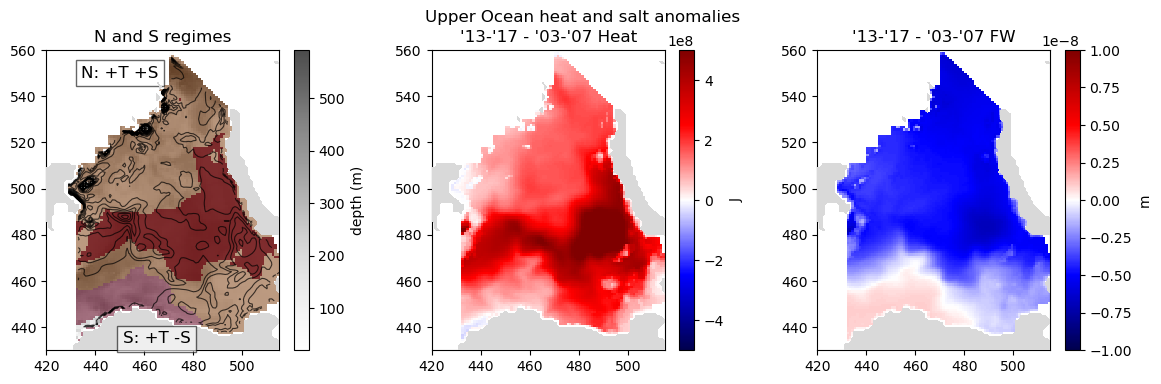

In [108]:
# plot just these three
fig = plt.figure(figsize = (12,4))

# plot the two masks as we did above and what they're based on
ax = plt.subplot(131)
cb = ax.pcolormesh(get_aste_tracer(mygrid['Depth'] * mymsk, nfx, nfy)[0], 
                   alpha=0.7, cmap="Greys")

contours = ax.contour(SSS_grad, colors="black", linewidths=0.8, levels=30,alpha=0.7)  # Adjust levels as needed
ax.clabel(contours, inline=True, fontsize=8)  # Label the contours

plt.colorbar(cb,label="depth (m)")

# Set axis limits
ax.set_xlim(420, 515)
ax.set_ylim(430, 560)

# First colormap: Southern portion
test1 = msk1.copy()
test1[test1 == 0] = np.nan  # Replace 0 with NaN for transparency
ax.pcolormesh(get_aste_tracer(test1, nfx, nfy)[0], alpha=0.5, cmap="RdBu")
ax.text(450, 550, "N: +T +S", color='black', fontsize=12, 
        ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6))
# Second colormap: Northern portion
test2 = msk2.copy()
test2[test2 == 0] = np.nan  # Replace 0 with NaN for transparency
ax.pcolormesh(get_aste_tracer(test2, nfx, nfy)[0], alpha=0.5, cmap="PuOr")
ax.text(465, 435, "S: +T -S", color='black', fontsize=12, 
        ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6),zorder=6)
# third colormap: subsect of northern portion
test3 = msk3.copy()
test3[test3 == 0] = np.nan  # Replace 0 with NaN for transparency
ax.pcolormesh(get_aste_tracer(test3, nfx, nfy)[0], alpha=0.7, cmap="Reds_r")
ax.contourf(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=5,levels=np.arange(-1,6,1))
ax.set_title("N and S regimes")

# do the second plot of the heat anomaly
ax = plt.subplot(132)
data = heat_content5yrs[-1] - heat_content5yrs[0]
data[data == 0] = np.nan
cb = ax.pcolormesh(get_aste_tracer(data,nfx,nfy)[0],cmap='seismic',vmin=-5e8,vmax=5e8)
plt.colorbar(cb,label="J")
ax.contourf(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=5,levels=np.arange(-1,6,1))
ax.set_xlim(420, 515)
ax.set_ylim(430, 560)
ax.set_title("'13-'17 - '03-'07 Heat")

# do the second plot of the heat anomaly
ax = plt.subplot(133)
data = fw_content5yrs[-1] - fw_content5yrs[0]
data[data == 0] = np.nan
cb = ax.pcolormesh(get_aste_tracer(data,nfx,nfy)[0],cmap='seismic',vmin=-1e-8,vmax=1e-8)
plt.colorbar(cb,label="m")
ax.contourf(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=5,levels=np.arange(-1,6,1))
ax.set_xlim(420, 515)
ax.set_ylim(430, 560)
ax.set_title("'13-'17 - '03-'07 FW")

fig.tight_layout(pad=2.0)  # Increase padding between subplots
plt.suptitle("Upper Ocean heat and salt anomalies")

plt.savefig(path + "regime_100m_with_SSSgrad.png",dpi=300)

In [ ]:
# create another mask just where we have the maximum change in the northern portion


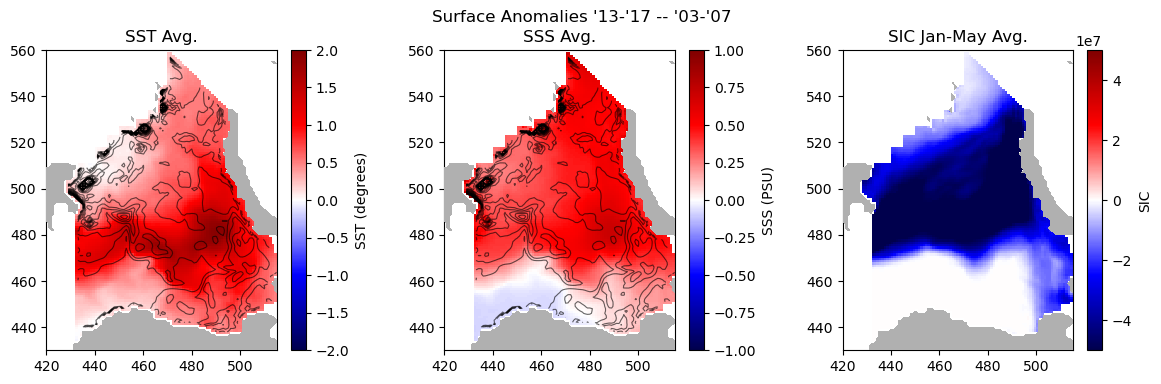

In [100]:
# plot this on top of the surface SST and SSS
# do the averaging so we can make a plot - regardless of if it is pretty; we need to do the two 5 year periods then anomaly
# plot just these three
fig = plt.figure(figsize = (12,4))

# First subplot: SST for the first 5 years
ax = plt.subplot(131)
cb = ax.pcolormesh(get_aste_tracer(SSTa * mymsk, nfx, nfy)[0], 
                   alpha=1, cmap="seismic",vmin=-2,vmax=2)
contours = ax.contour(SSS_grad, colors="black", linewidths=0.8, levels=30,alpha=0.6)  # Adjust levels as needed
ax.clabel(contours, inline=True, fontsize=8)  # Label the contours
plt.colorbar(cb,label="SST (degrees)")
# Set axis limits
ax.set_xlim(420, 515)
ax.set_ylim(430, 560)
ax.contourf(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=5,levels=np.arange(-1,6,1))
ax.set_title("SST Avg.")

# Second subplot: SSS for the first 5 years
ax = plt.subplot(132)
cb = ax.pcolormesh(get_aste_tracer(SSSa * mymsk, nfx, nfy)[0], 
                   alpha=1, cmap="seismic",vmin=-1,vmax=1)
contours = ax.contour(SSS_grad, colors="black", linewidths=0.8, levels=30,alpha=0.6)  # Adjust levels as needed
ax.clabel(contours, inline=True, fontsize=8)  # Label the contours
plt.colorbar(cb,label="SSS (PSU)")
# Set axis limits
ax.set_xlim(420, 515)
ax.set_ylim(430, 560)
ax.contourf(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=5,levels=np.arange(-1,6,1))
ax.set_title("SSS Avg.")

# Third subplot: SIC average for the first 5 years
ax = plt.subplot(133)
cb = ax.pcolormesh(get_aste_tracer(SICa * mymsk, nfx, nfy)[0], 
                   alpha=1, cmap="seismic",vmin=-5e7,vmax=5e7)
plt.colorbar(cb,label="SIC")
# Set axis limits
ax.set_xlim(420, 515)
ax.set_ylim(430, 560)
ax.contourf(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=5,levels=np.arange(-1,6,1))
ax.set_title("SIC Jan-May Avg.")

fig.tight_layout(pad=2.0)  # Increase padding between subplots
plt.suptitle("Surface Anomalies '13-'17 -- '03-'07")

plt.savefig(path + "surface_anomalies_withSSSgrad.png",dpi=300)

# Figure 1

In [109]:
# load the masks
data = np.load('/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/Lind2018/masks.npz')

# Access the saved masks
msk1 = data['msk1']  # mask for heating and freshening
msk2 = data['msk2']  # mask for heating and salting
msk3 = data['msk3']  # mask for heating and salting but subsect

In [110]:
ntimes = 12*len(allyears)

## Figure 1a

In [16]:
boundary = np.zeros_like(msk1)
test1 = msk1.copy() # for the Southern portion

boundary[test1 == 1] = 1

test2 = msk2.copy() # for the Northern portion
boundary[test2 == 1] = 2

Text(0.5, 1.0, 'N and S regimes')

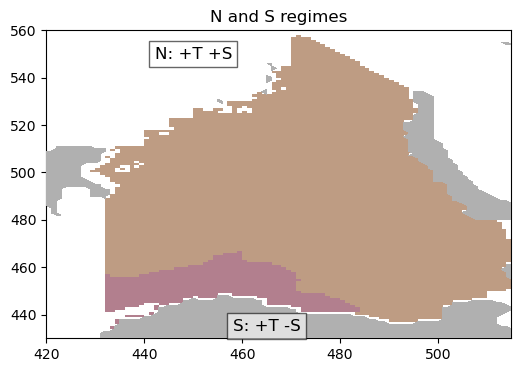

In [19]:
# can we just plot the line between the two regimes?
fig = plt.figure(figsize = (6,4))

# we want to get the line between these two
# first make an array of the same shape as msk1 and msk2
# fill each with 1 for north section and 2 for south section
# only keep the region where they're touching

boundary = np.zeros_like(msk1)

# plot the two masks as we did above and what they're based on
ax = plt.subplot(111)

# Set axis limits
ax.set_xlim(420, 515)
ax.set_ylim(430, 560)

# First colormap: Southern portion
test1 = msk1.copy()
test1[test1 == 0] = np.nan  # Replace 0 with NaN for transparency
ax.pcolormesh(get_aste_tracer(test1, nfx, nfy)[0], alpha=0.5, cmap="RdBu")
# Add label for the first colormap
ax.text(450, 550, "N: +T +S", color='black', fontsize=12, 
        ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6))

# Second colormap: Northern portion
test2 = msk2.copy()
test2[test2 == 0] = np.nan  # Replace 0 with NaN for transparency
ax.pcolormesh(get_aste_tracer(test2, nfx, nfy)[0], alpha=0.5, cmap="PuOr")
# Add label for the second colormap
ax.text(465, 435, "S: +T -S", color='black', fontsize=12, 
        ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6),zorder=6)
ax.contourf(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=5,levels=np.arange(-1,6,1))
ax.set_title("N and S regimes")


Text(0.5, 1.0, "'13-'17 - '03-'07 Heat Anomaly, 0-100m")

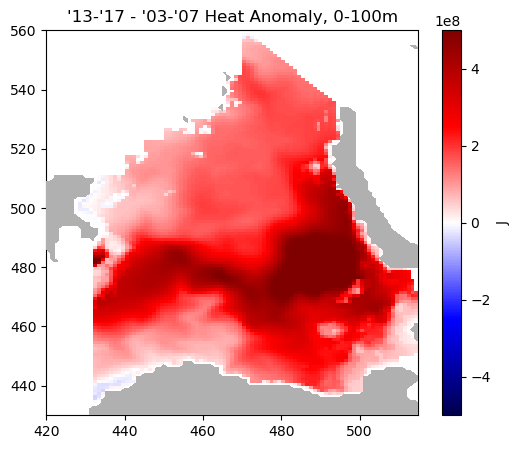

In [20]:
# do the second plot of the heat anomaly
plt.figure(figsize = (6,5))

# First figure: add the upper ocean heat anomaly
ax = plt.subplot(111)
data = heat_content5yrs[-1] - heat_content5yrs[0]
data[data == 0] = np.nan
cb = ax.pcolormesh(get_aste_tracer(data,nfx,nfy)[0],cmap='seismic',vmin=-5e8,vmax=5e8)
plt.colorbar(cb,label="J")
ax.contourf(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=5,levels=np.arange(-1,6,1))
ax.set_xlim(420, 515)
ax.set_ylim(430, 560)
ax.set_title("'13-'17 - '03-'07 Heat Anomaly, 0-100m")

# add the line between the two regimes that we identify


## Figure 1c

In [113]:
# do this by looping through the salt and heat -- we want to make an average of these as depth
# ArcWater = np.zeros((ntimes,nz,ny,nx))   # file to store True/False Arctic Water exists as a mask
# save the average T and S profiles with depth

thetaprofile_msk2 = np.zeros((nz,ntimes))
thetaprofile_msk3 = np.zeros((nz,ntimes))

# do indexing in years for the layers
iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ##########################################################################################
    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    # read the fldList
    
    file_name = 'budg3d_snap_set2'
    meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg3d_snap_set2["fldList"])
    varnames = np.array(["THETADR","SALTDR"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
        
  
    for i in range(len(tsstr)):
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        #SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR = np.reshape(THETADRi,(nz,ny,nx))
        #SALTDR = np.reshape(SALTDRi,(nz,ny,nx))

        # do for not subsect mask
        thisTHETA = THETADR/DRF3d/hfC * np.tile(msk2[np.newaxis,:,:],(50,1,1))    # degC
        thisTHETA[thisTHETA == 0] = np.nan
        thetaprofile_msk2[:,iy] = np.nanmean(thisTHETA,axis=(1,2))

        # do for subsect mask
        thisTHETA = THETADR/DRF3d/hfC * np.tile(msk3[np.newaxis,:,:],(50,1,1))    # degC
        thisTHETA[thisTHETA == 0] = np.nan
        thetaprofile_msk3[:,iy] = np.nanmean(thisTHETA,axis=(1,2))
        iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [114]:
# make a custom colormap

bounds = [-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4] # temperature bounds for the colormap
colors = ["#93c6dd","#b6d7e9","#d1e6f1","#f7f7f7","#fcefe8","#fedbc7","#f4a683","#e98366","#d75f4f","#b2172c","#8d0722","#66001e"]
len(colors)

12

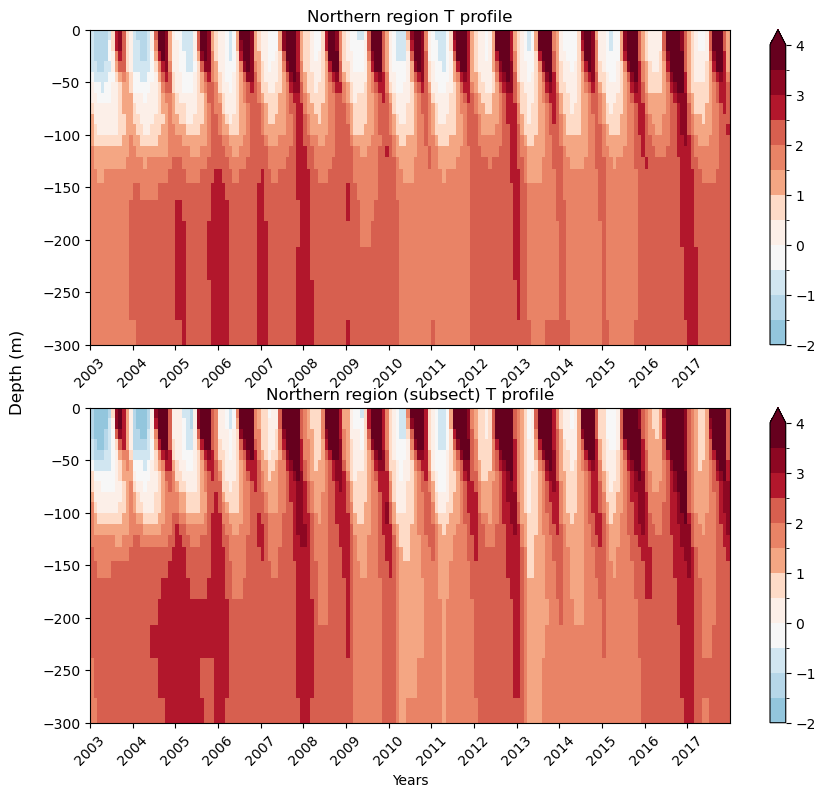

In [123]:
XVc,YVc = np.meshgrid(np.arange(181),mygrid['RF'])
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

# First plot: full Northern Subsection
fig = plt.figure(figsize=(10,9))

ax = plt.subplot(211)
cb = ax.pcolormesh(XVc, YVc, thetaprofile_msk2,cmap=cmap,norm=norm)
ax.set_ylim(-300,0)
ax.set_title("Northern region T profile")
plt.colorbar(cb,extend="max")
xtick_positions = np.arange(0, 180, 12)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2003 to 2017
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability

# Second plot: subsect of Northern Subsection
ax = plt.subplot(212)
cb = ax.pcolormesh(XVc, YVc, thetaprofile_msk3,cmap=cmap,norm=norm)
ax.set_ylim(-300,0)
ax.set_title("Northern region (subsect) T profile")
plt.colorbar(cb,extend="max")
xtick_positions = np.arange(0, 180, 12)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2003 to 2017
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability

# fix the labels
ax.set_xlabel("Years")
fig.supylabel("Depth (m)")
fig.subplots_adjust(left=0.1)  # Increase left margin (default ~0.125)

plt.savefig(path + "Lind1c_totalTprofile_2sets.png",dpi=300)

In [124]:
# smooth the seasonal cycle for the northern profile
thetaprofile_reshaped = thetaprofile_msk2.reshape(50, 15, 12)
climatology = np.mean(thetaprofile_reshaped, axis=1)  # Shape: (50, 12)
climatology_expanded = np.repeat(climatology[:, np.newaxis, :], 15, axis=1)
thetaprofile_deseasoned = thetaprofile_msk2 - climatology_expanded.reshape(50, 180)

# smooth the seasonal cycle for the northern profile subsect
thetaprofile_reshaped3 = thetaprofile_msk3.reshape(50, 15, 12)
climatology3 = np.mean(thetaprofile_reshaped, axis=1)  # Shape: (50, 12)
climatology_expanded3 = np.repeat(climatology3[:, np.newaxis, :], 15, axis=1)
thetaprofile_deseasoned3 = thetaprofile_msk3 - climatology_expanded3.reshape(50, 180)

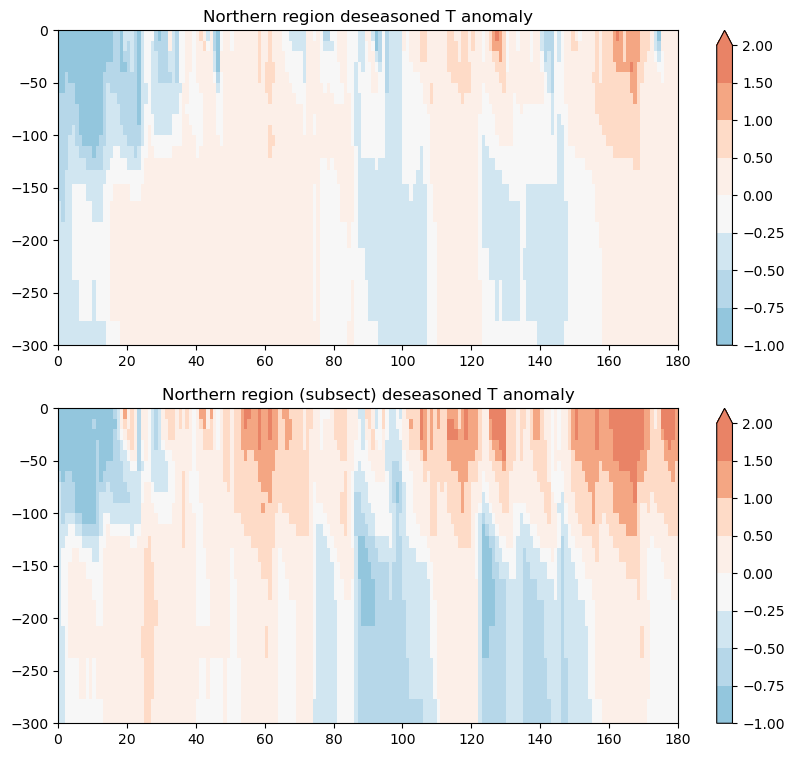

In [126]:
# reset the colormap for the deseasoned profile
bounds = [-1, -0.75, -0.5, -0.25, 0, 0.5, 1, 1.5, 2]
# Adjusted colors list (same color range but mapped to new bounds)
colors = [
    "#93c6dd",  # Deep Blue (-1 to -0.75)
    "#b6d7e9",  # Medium Blue (-0.75 to -0.5)
    "#d1e6f1",  # Light Blue (-0.5 to -0.25)
    "#f7f7f7",  # White (-0.25 to 0)
    "#fcefe8",  # Light Peach (0 to 0.5)
    "#fedbc7",  # Pale Orange (0.5 to 1)
    "#f4a683",  # Orange-Red (1 to 1.5)
    "#e98366",  # Medium Red (1.5 to 2)
]

XVc,YVc = np.meshgrid(np.arange(181),mygrid['RF'])
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N, clip=True)


fig = plt.figure(figsize=(10,9))
ax = plt.subplot(211)
cb = ax.pcolormesh(XVc, YVc, thetaprofile_deseasoned,cmap=cmap,norm=norm)
ax.set_ylim(-300,0)
ax.set_title("Northern region deseasoned T anomaly")
plt.colorbar(cb,extend="max")

ax = plt.subplot(212)
cb = ax.pcolormesh(XVc, YVc, thetaprofile_deseasoned3,cmap=cmap,norm=norm)
ax.set_ylim(-300,0)
ax.set_title("Northern region (subsect) deseasoned T anomaly")
plt.colorbar(cb,extend="max")

plt.savefig(path + "Lind1c_anomalies.png",dpi=300)

In [134]:
# Increased resolution: More temperature bounds
bounds = [-2, -1.75, -1.5, -1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 
          1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]

# Expanded color list to match new bounds (length should be len(bounds) - 1)
colors = [
    "#93c6dd",  # Deep Blue (-2 to -1.75)
    "#a7cfe2",  # Medium Blue (-1.75 to -1.5)
    "#b6d7e9",  # Light Blue (-1.5 to -1.25)
    "#c8e0ef",  # Lighter Blue (-1.25 to -1)
    "#d1e6f1",  # Pale Blue (-1 to -0.75)
    "#e0eff6",  # Near White Blue (-0.75 to -0.5)
    "#f1f5fa",  # Almost White (-0.5 to -0.25)
    "#f7f7f7",  # Pure White (-0.25 to 0)
    "#fdf3ed",  # Near White Peach (0 to 0.25)
    "#fcefe8",  # Light Peach (0.25 to 0.5)
    "#fcdcc9",  # Peach Orange (0.5 to 0.75)
    "#fedbc7",  # Light Orange (0.75 to 1)
    "#fdb896",  # Orange (1 to 1.25)
    "#f4a683",  # Dark Orange (1.25 to 1.5)
    "#f08d71",  # Light Red-Orange (1.5 to 1.75)
    "#e98366",  # Light Red (1.75 to 2)
    "#e36d5b",  # Medium Red (2 to 2.25)
    "#d75f4f",  # Darker Red (2.25 to 2.5)
    "#c94745",  # Deep Red (2.5 to 2.75)
    "#b2172c",  # Strong Red (2.75 to 3)
    "#9d1126",  # Dark Red (3 to 3.25)
    "#8d0722",  # Very Dark Red (3.25 to 3.5)
    "#75041a",  # Deepest Red (3.5 to 3.75)
    "#66001e"   # Near Black Red (3.75 to 4)
]

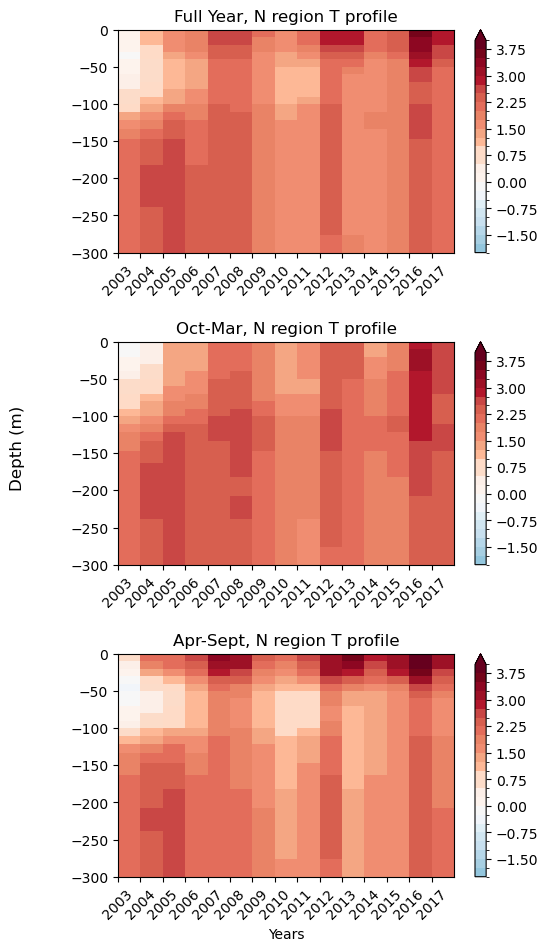

In [136]:
data = thetaprofile_msk3

# plot one block for each year to see how this would look
XVc,YVc = np.meshgrid(np.arange(16),mygrid['RF'])
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

# Define winter and summer month indices (0-based: Jan=0, Dec=11)
winter_months = [9, 10, 11, 0, 1, 2]  # October - March
summer_months = [3, 4, 5, 6, 7, 8]  # April - September

# make the profiles for each plot, do the total year, ice growth, then ice decline proifile
thetaprofile_reshaped = data.reshape(50,15,12)

# Compute winter and summer averages separately
winter_selected = thetaprofile_reshaped[:, :, winter_months]  # Shape: (50, 15, 6)
summer_selected = thetaprofile_reshaped[:, :, summer_months]  # Shape: (50, 15, 6)

thetaprofile_winter_avg = np.nanmean(winter_selected, axis=2)  # Shape: (50, 15)
thetaprofile_summer_avg = np.nanmean(summer_selected, axis=2)  # Shape: (50, 15)
totalprofile_avg = np.nanmean(thetaprofile_reshaped,axis=2) # creates an average value for each year


# do the plotting
fig = plt.figure(figsize = (6,11))
fig.subplots_adjust(hspace=0.4)  # Adjust vertical space (increase if needed)


ax = plt.subplot(311)
cb = ax.pcolormesh(XVc, YVc, totalprofile_avg,cmap=cmap,norm=norm)
ax.set_ylim(-300,0)
ax.set_title("Full Year, N region T profile")
plt.colorbar(cb,extend="max")
xtick_positions = np.arange(0, 15, 1)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2003 to 2017
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability

ax = plt.subplot(312)
cb = ax.pcolormesh(XVc, YVc, thetaprofile_winter_avg,cmap=cmap,norm=norm)
ax.set_ylim(-300,0)
ax.set_title("Oct-Mar, N region T profile")
plt.colorbar(cb,extend="max")
xtick_positions = np.arange(0, 15, 1)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2003 to 2017
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability

ax = plt.subplot(313)
cb = ax.pcolormesh(XVc, YVc, thetaprofile_summer_avg,cmap=cmap,norm=norm)
ax.set_ylim(-300,0)
ax.set_title("Apr-Sept, N region T profile")
plt.colorbar(cb,extend="max")
xtick_positions = np.arange(0, 15, 1)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2003 to 2017
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability

ax.set_xlabel("Years")
fig.supylabel("Depth (m)")
fig.subplots_adjust(left=0.2)  # Increase left margin (default ~0.125)

plt.savefig(path + "Lind1c_seasonal_profile_Nregionsubsect.png",dpi=300)

## Figure 1b

In [138]:
heat_content_1b = heat_content.reshape(15*12,ny,nx)

# do the masking with msk2 and msk3
heat_content_1b2 = heat_content_1b * np.tile(msk2[np.newaxis,:,:],(180,1,1))
heat_content_1b3 = heat_content_1b * np.tile(msk3[np.newaxis,:,:],(180,1,1))


# make an array to store the heat values
tot_heat2 = np.nansum(heat_content_1b2,axis = (1,2))
tot_heat3 = np.nansum(heat_content_1b3,axis = (1,2))

In [139]:
def deseason(tot_heat):
    tot_heat_sample = tot_heat.reshape(15,12)

    # subtract the monthly mean based on the data - remove monthly variability
    monthly_mean = np.nanmean(tot_heat_sample, axis=0)
    monthly_mean = np.repeat(monthly_mean[np.newaxis,:], 15, axis=0)
    monthly_mean.shape
    deseasonalized_tot_heat = (tot_heat_sample - monthly_mean).reshape(180)
    
    # add back the annual mean - add back in the annual variability
    annual_mean = np.nanmean(tot_heat_sample, axis=1,keepdims=True)
    deseasonalized_tot_heat = ((tot_heat_sample - monthly_mean) + annual_mean).reshape(180)

    return deseasonalized_tot_heat

deseasonalized_tot_heat2 = deseason(tot_heat2)
deseasonalized_tot_heat3 = deseason(tot_heat3)

In [145]:
# use fw_content and do the same as above - put both stacked in a subplot

# masking with the northern region
# we want one value, so we should select from the mask and sum 
fw_content_3b = fw_content.reshape(15*12,ny,nx)

# do the masking with msk2
fw_content_3b = fw_content_3b * np.tile(msk2[np.newaxis,:,:],(180,1,1))

# make an array to store the heat values
tot_fw = np.nansum(fw_content_3b,axis = (1,2))

In [146]:
deseasonalized_tot_fw2 = deseason(tot_fw)

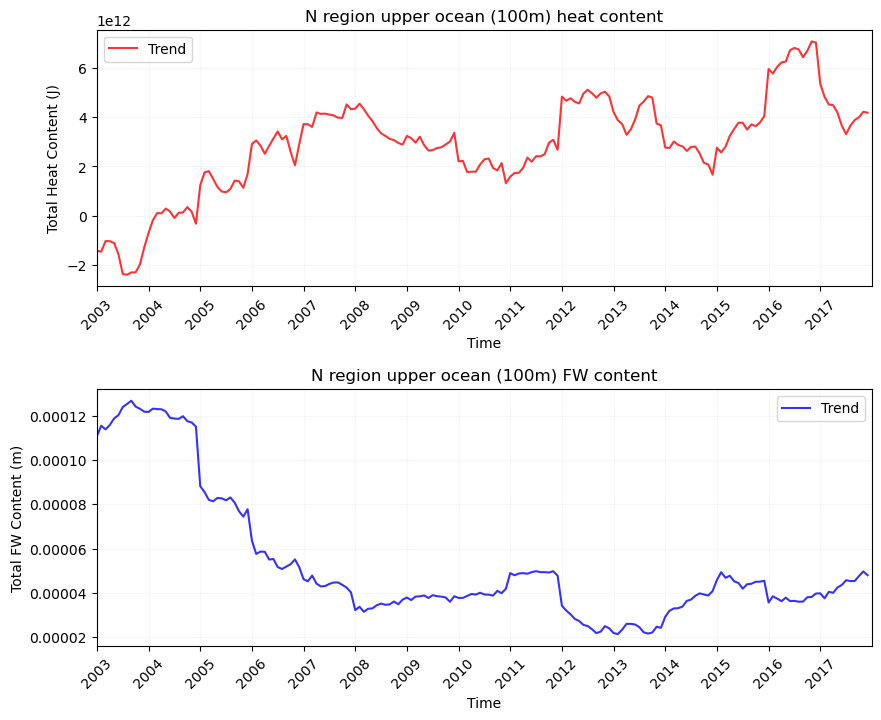

In [151]:
fig = plt.figure(figsize = (10,8))

# first subplot - heat trend for the northern portion
ax = plt.subplot(211)
# ax.plot(np.arange(0,180,1),tot_heat,color="black",alpha=0.2,label="heat (J)")
ax.plot(np.arange(0,180,1),deseasonalized_tot_heat2,color="red",alpha=0.8,label="Trend")
ax.set_ylabel("Total Heat Content (J)")
ax.set_xlabel("Time")
ax.legend(loc="best")
plt.title("N region upper ocean (100m) heat content")

# add the labels
xtick_positions = np.arange(0, 180, 12)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2003 to 2017
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability
ax.grid(alpha=0.1)
ax.set_xlim(0,180)


# second subplot - freshwater trend for the northern portion
ax = plt.subplot(212)
# ax.plot(np.arange(0,180,1),tot_fw,color="black",alpha=0.2,label="FW (m)")
ax.plot(np.arange(0,180,1),deseasonalized_tot_fw2,color="blue",alpha=0.8,label="Trend")
ax.set_ylabel("Total FW Content (m)")
ax.set_xlabel("Time")
ax.legend(loc="best")
plt.title("N region upper ocean (100m) FW content")

# add the labels
xtick_positions = np.arange(0, 180, 12)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2003 to 2017
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability
ax.grid(alpha=0.1)
ax.set_xlim(0,180)

plt.subplots_adjust(hspace=0.4)  # Increase vertical spacing between subplots


plt.savefig(path + "Lind_Nregion_timeseries.png",dpi=300)

In [154]:
# let's try to recalculate these to get them in the same units as the Lind paper

# loop through the years to create the timeseries
# alldatetimes = np.array([])
# FW_times = np.array([])
# Heat_times = np.array([])  # this does not make sense as variable name

iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ##########################################################################################
    # get the depth values

    # changed - only set tmp1 here
    tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m

    ##########################################################################################
    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

    # get theta and salt alone so we can use for the freshwater content
    THETA = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    SALT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
        THETA[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']  # degC
        SALT[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']   # PSU

    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        
        thisTHETADR = THETADR[i]/DRF3d/mygrid['hFacC'] * mymsk[np.newaxis,:,:]    # degC
        thisheat = thisTHETADR * myparms['rcp']   # degC * J/m^3.degC = J/m^3
        thisheat = thisheat * tmp1     # J/m^3 * m = J/m^2   CHANGED FROM PREVIOUS VERSION
        thisheat = thisheat[:dterm]   # upper mygrid['DRF'][:dterm] m


        heat_content[iy,i,:,:] = np.nansum(thisheat,axis=0)            # vertical integration (J)

    ##########################################################################################
    # get the freshwater content values
    # set up for time averaging
    sref = 34.8#41.05      # PSU
    # filter = drf3d.copy() * mygrid['hFacC']
    # filter[filter >= 254] = np.nan
    # filter[filter < 254] = 1
    FWcontent = np.full((len(tsstr),ny,nx),np.nan)
    
    for i in range(len(tsstr)): 
        # for calculating freshwater content:
            # FW volume * (1- salinity/reference salinity)    m^3
            # integrate over surface to mygrid['DRF'][:dterm] m based on the np.where(np.cumsum(mygrid['DRF'])<X meters deep)
            # look at the time average of this
        
        # do step 1 to get FW volume and only look at the values at less than X m
        saltnorm = 1-(SALT[i]/sref)         # PSU/PSU
        FWvol = tmp1 * (1-SALT[i]/sref)   # m^3 * PSU/PSU
        FWvol /=  RAC3                      # m
        FWvol = FWvol[:dterm]
        
        # vertically integrate
        FWcontent[i] = np.nansum(FWvol,axis=0) * mymsk          # vertical integration, m

        # add as a map to the bigger array
        fw_content[iy,i,:,:] = FWcontent[i]

    print()
    iy += 1

2003

2004

2005

2006

2007

2008

2009

2010

2011

2012

2013

2014

2015

2016

2017



In [155]:
# copy syntax for getting the trend in these
heat_content_1b = heat_content.reshape(15*12,ny,nx)

# do the masking with msk2 and msk3
heat_content_1b2 = heat_content_1b * np.tile(msk2[np.newaxis,:,:],(180,1,1))
heat_content_1b3 = heat_content_1b * np.tile(msk3[np.newaxis,:,:],(180,1,1))

# make an array to store the heat values
tot_heat2 = np.nansum(heat_content_1b2,axis = (1,2))
tot_heat3 = np.nansum(heat_content_1b3,axis = (1,2))

deseasonalized_tot_heat2 = deseason(tot_heat2)
deseasonalized_tot_heat3 = deseason(tot_heat3)

# for freshwater deseasoning
# masking with the northern region
# we want one value, so we should select from the mask and sum 
fw_content_3b = fw_content.reshape(15*12,ny,nx)

# do the masking with msk2
fw_content_3b = fw_content_3b * np.tile(msk2[np.newaxis,:,:],(180,1,1))

# make an array to store the heat values
tot_fw = np.nansum(fw_content_3b,axis = (1,2))

deseasonalized_tot_fw2 = deseason(tot_fw)

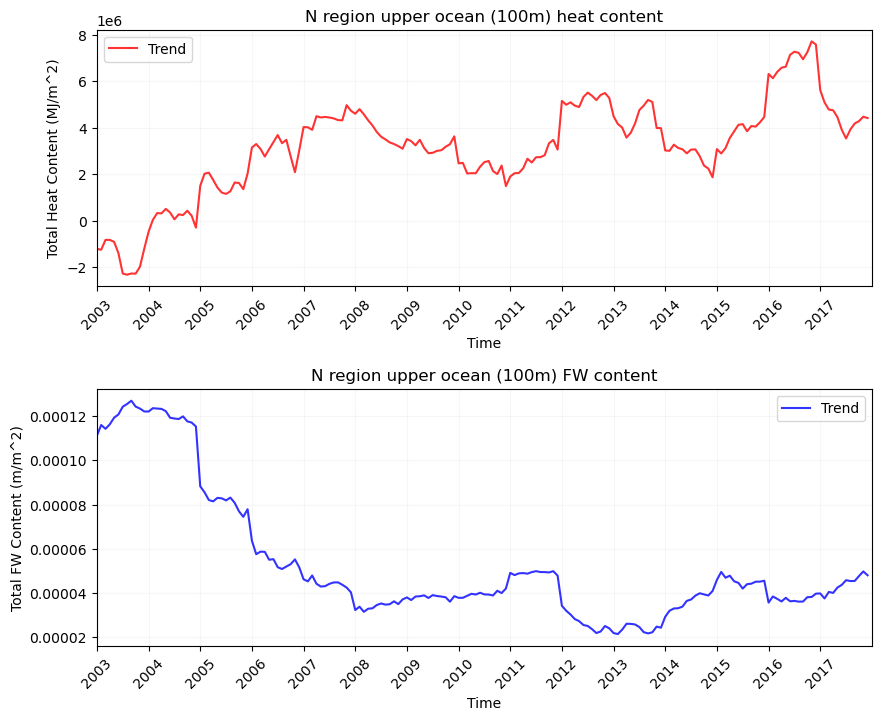

In [157]:
fig = plt.figure(figsize = (10,8))

# first subplot - heat trend for the northern portion
ax = plt.subplot(211)
# ax.plot(np.arange(0,180,1),tot_heat,color="black",alpha=0.2,label="heat (J)")
ax.plot(np.arange(0,180,1),deseasonalized_tot_heat2/1e6,color="red",alpha=0.8,label="Trend")
ax.set_ylabel("Total Heat Content (MJ/m^2)")
ax.set_xlabel("Time")
ax.legend(loc="best")
plt.title("N region upper ocean (100m) heat content")

# add the labels
xtick_positions = np.arange(0, 180, 12)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2003 to 2017
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability
ax.grid(alpha=0.1)
ax.set_xlim(0,180)


# second subplot - freshwater trend for the northern portion
ax = plt.subplot(212)
# ax.plot(np.arange(0,180,1),tot_fw,color="black",alpha=0.2,label="FW (m)")
ax.plot(np.arange(0,180,1),deseasonalized_tot_fw2,color="blue",alpha=0.8,label="Trend")
ax.set_ylabel("Total FW Content (m/m^2)")
ax.set_xlabel("Time")
ax.legend(loc="best")
plt.title("N region upper ocean (100m) FW content")

# add the labels
xtick_positions = np.arange(0, 180, 12)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2003 to 2017
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability
ax.grid(alpha=0.1)
ax.set_xlim(0,180)

plt.subplots_adjust(hspace=0.4)  # Increase vertical spacing between subplots


# plt.savefig(path + "Lind_Nregion_timeseries.png",dpi=300)

# ABOVE MIGHT BE WRONG! FIX

# Figure 2 - column shift

In [128]:
# we need to first ID the cells in the masks that are surface, Arctic, Atlantic and label them with a number as a mask

In [129]:
# now calculate the average temperature of each layer as a timeseries

In [131]:
# now calculate the average salinity as a timeseries

In [132]:
# do the deseasoning process